In [1]:
import os 
os.chdir('../../')
print("Current working directory is now: ", os.getcwd())

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 

from utils.load_settings import load_settings
from utils.fairness_functions import compute_calibration_discrete_score, parse_calibration_matrix
from utils.plot_fairness import plot_calibration_for_score_on_problem

%matplotlib inline
# load parameters
settings = load_settings()

Current working directory is now:  C:\Users\Caroline Wang\OneDrive\Duke\Criminal Recidivism\psa-analysis


Read in data, preprocess it

In [2]:
broward_data = pd.read_csv("broward/data/broward_data.csv")
broward_arnold_compas = pd.read_csv("broward/data/broward_arnold.csv")

for decoder_name, decoder_dict in settings['decoders'].items():
    broward_arnold_compas = broward_arnold_compas.replace({decoder_name: decoder_dict})

broward_arnold_compas.rename(columns=settings['decoders']['label'], inplace=True)

In [3]:
broward_arnold_compas = (broward_arnold_compas[['person_id', 'screening_date', 
                                        'arnold_nca_raw', 'arnold_nca', 
                                        'arnold_nvca_raw', 'arnold_nvca', 
                                        'Risk of Recidivism_decile_score', 
                                        'Risk of Violence_decile_score',
                                        'sex', 'race'] 
                                       + settings["labels"]]
                            .rename(columns={"Risk of Recidivism_decile_score": "COMPAS General",
                                             "Risk of Violence_decile_score": "COMPAS Violence"}))

# wide to long on sensitive attrs
broward_long = (pd.melt(broward_arnold_compas, id_vars =['person_id', 'screening_date'], value_vars=['sex', 'race'])
                         .rename({'variable': 'Attribute',
                                  'value': 'Attribute Value'},
                                   axis=1))
broward_long = broward_long.merge(broward_arnold_compas.drop(columns=['sex', 'race']),
                                                    on = ['person_id', 'screening_date'],
                                                    how = 'left')
broward_long.head()

,person_id,screening_date,Attribute,Attribute Value,arnold_nca_raw,arnold_nca,arnold_nvca_raw,arnold_nvca,COMPAS General,COMPAS Violence,...,drug_two_year,property_two_year,misdemeanor_two_year,felony_two_year,violent_two_year,drug_six_month,property_six_month,misdemeanor_six_month,felony_six_month,violent_six_month
0,1001,2014-02-03,sex,male,9,6,6,Yes,9,5,...,0,0,0,0,0,0,0,0,0,0
1,101,2013-01-13,sex,male,7,5,2,No,1,1,...,0,0,1,0,1,0,0,0,0,0
2,101,2014-02-02,sex,male,9,6,5,Yes,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1015,2014-01-22,sex,male,9,6,6,Yes,4,2,...,0,0,0,0,0,0,0,0,0,0
4,1016,2013-04-15,sex,male,8,5,4,Yes,9,8,...,0,0,0,1,1,0,0,0,1,1


## Calibration of Arnold PSA and COMPAS

First type of calibration: score of model should be reflective of true probability of recid

$P(Y = 1 | Score = score) = score$

Second type of calibration: calibration across groups should be the same 

$P(Y=1|S=s,G=g_1)=P(Y=1|S=s,G=g_2)$

Idea: plot overall calibration curve in bold black, and plot calibration curves for each group (race, sex) in different colors 

In [4]:
from utils.plotting_helpers import safe_save_plt

def plot_calibration_for_score_on_problem(calib: pd.DataFrame, 
                                          calib_grps: pd.DataFrame,
                                          problem_name: str,
                                          score_name: str,
                                          region: str,
                                          xtick_labels=None,
                                          rotate_xticks=False,
                                          include_legend=True,
                                          save_path=None):
    """Plots calibration for risk scores which are NONBINARY AND DISCRETE 
    (i.e. Arnold NCA, COMPAS)
    Keyword Arguments:
        calib: df with columns [score_name, P(Y = 1 | Score = score)]; should contain the probability of 
                recidivism for each score. 
        calib_grps: df with columns [score_name, Attribute Value, P(Y = 1 | Score = score, Attr=attr)]; 
                                should contain the prob of recidivism for each sensitive group and score 
        problem_name: variable name of the prediction problem for this plot 
        score_name: 
    """
    
    plt.figure(figsize=(8, 5.5))
    plt.style.use('ggplot')

    # calibration reference line doesn't make sense here
    # overall calibration 
    plt.plot(calib[score_name], 
             calib['P(Y = 1 | Score = score)'], 
             color='black', marker='o', 
             linewidth=1, markersize=4,
             label='All individuals')

    # group level calibration 
    colors=['red', 'green', 'orange', 'maroon', 'royalblue', 'mediumslateblue']
    for i, (name, group_df) in enumerate(calib_grps.groupby("Attribute Value")):
        if name == 'female' or name == 'male':
            plt.plot(group_df[score_name], 
                     group_df['P(Y = 1 | Score = score, Attr = attr)'], 
                     color=colors[i], marker='o', linewidth=1, markersize=4,
                     linestyle='--',
                     label=name)
        else:
            plt.plot(group_df[score_name], 
                     group_df['P(Y = 1 | Score = score, Attr = attr)'], 
                     color=colors[i], marker='o', linewidth=1, markersize=4,
                     label=name)

    # axes settings
    if xtick_labels is not None:
        plt.xticks(np.arange(len(xtick_labels)), xtick_labels)
    plt.xlabel(f"{score_name} score", fontsize=25)

    plt.ylim(0,1)
    plt.ylabel('P(Y = 1 | Score = score, \nAttr = attr)', fontsize=25)

    # Create legend, add title, format & show/save graphic
    if include_legend:
        plt.legend(fontsize=20, ncol=2, framealpha=0.3)
    plt.title(f'Calib. of {score_name} on \n{problem_name} in {region}', fontsize=25)

    if rotate_xticks:
        plt.tick_params(axis="x", labelsize=20, rotation=25)
    else:
        plt.tick_params(axis="x", labelsize=20)

    plt.tick_params(axis="y", labelsize=25)

    if save_path is not None: 
        safe_save_plt(plt, save_path)
        
    plt.show()
    plt.close()
    return


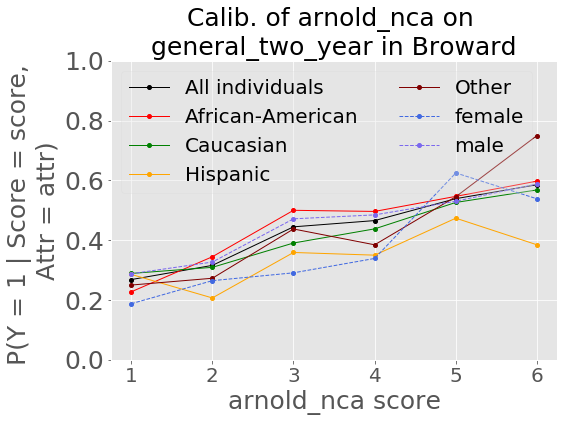

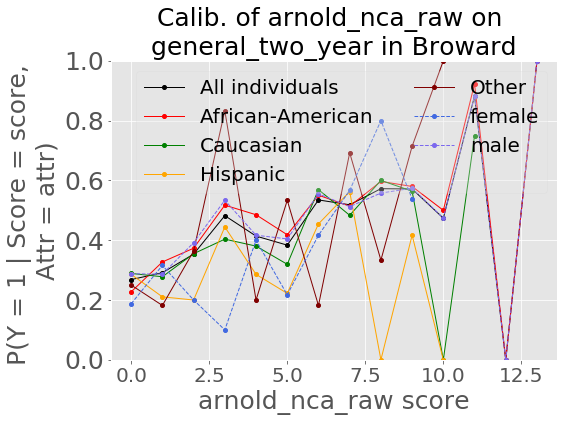

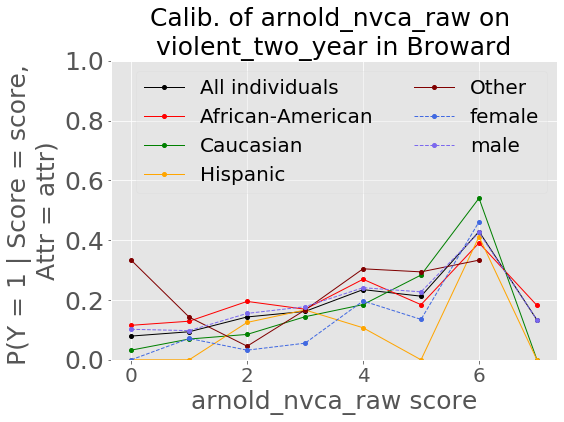

In [67]:
# calibration of PSA
scores_problem_dict = {'arnold_nca': ['general_two_year',
                                      'broward/logs/fairness_results/calibration_visualizations/arnold/arnold_nca_calib.pdf'],
                       'arnold_nca_raw': ['general_two_year', 
                                          'broward/logs/fairness_results/calibration_visualizations/arnold/arnold_nca_raw_calib.pdf'],
                       'arnold_nvca_raw': ['violent_two_year', 
                                           'broward/logs/fairness_results/calibration_visualizations/arnold/arnold_nvca_raw_calib.pdf']
                      }

for score_name, (problem_name, save_path) in scores_problem_dict.items():
    calib, calib_grps = compute_calibration_discrete_score(long_df=broward_long, 
                                                            problem_name=problem_name, 
                                                            score_name=score_name)
    plot_calibration_for_score_on_problem(calib=calib,
                                          calib_grps=calib_grps,
                                           problem_name=problem_name,
                                           score_name=score_name,
                                           region="Broward",
                                           save_path=save_path,
                                           include_legend=True)

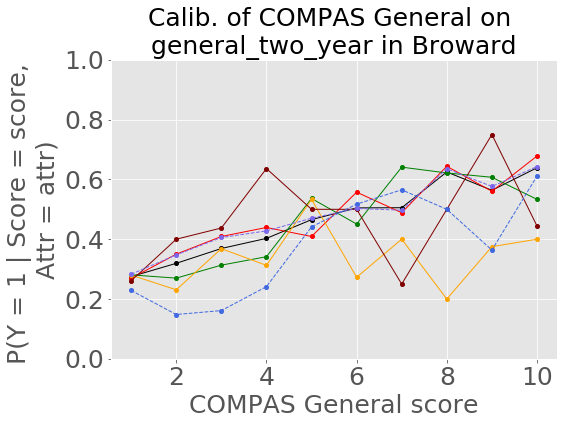

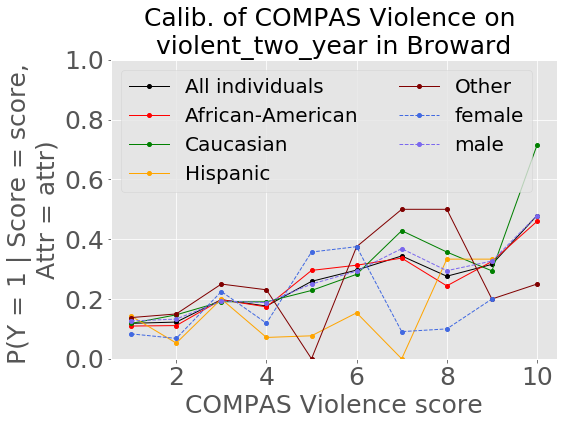

In [38]:
# calibration of COMPAS
scores_problem_dict = {'COMPAS General': ['general_two_year',
                                           'broward/logs/fairness_results/calibration_visualizations/compas/compas_recid_calib.pdf'],
                       'COMPAS Violence': ['violent_two_year',
                                           'broward/logs/fairness_results/calibration_visualizations/compas/compas_violence_calib.pdf']}

for score_name, (problem_name, save_path) in scores_problem_dict.items():
    
    calib, calib_grps = compute_calibration_discrete_score(long_df=broward_long, 
                                                            problem_name=problem_name, 
                                                            score_name=score_name)
    include_legend=False
    if score_name == "COMPAS Violence":
        include_legend=True
    plot_calibration_for_score_on_problem(calib=calib, 
                                          calib_grps=calib_grps,
                                           problem_name=problem_name,
                                           score_name=score_name,
                                           region="Broward",
                                           include_legend=include_legend,
                                           save_path=save_path)

## Calibration of EBM and RiskSLIM

In [5]:
# read in calibration data for all problems 
calibration_data = {}
for time_period in [
#                     "six_month", 
                    "two_year"
                    ]:
    
    for problem in ['general', 
                    'violent', 
#                     'drug', 
#                     'misdemeanor', 
#                     'property', 
#                     'felony'
                   ]:
        problem_path = "broward/calibration_matrix/" + time_period + "/" + problem
        dircontents = os.listdir()
        onlyfiles = [f for f in os.listdir(problem_path) if os.path.isfile(os.path.join(problem_path, f))]
        
        for filename in onlyfiles:
            model_name = filename.split("_")[0]
            if model_name in ['ebm', 'riskslim', 'stumps']:
                calibration_data["-".join((problem, time_period, model_name))] = pd.read_csv(problem_path + "/" + filename)

calibration_data.keys()


dict_keys(['general-two_year-ebm', 'general-two_year-riskslim', 'general-two_year-stumps', 'violent-two_year-ebm', 'violent-two_year-riskslim', 'violent-two_year-stumps'])

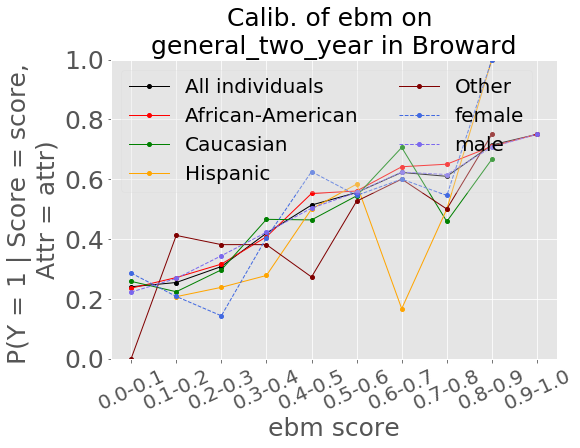

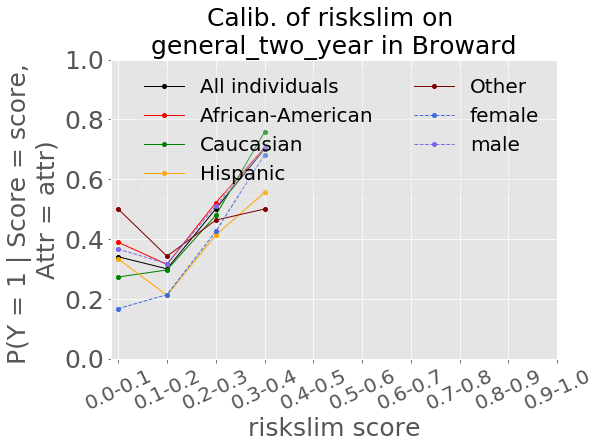

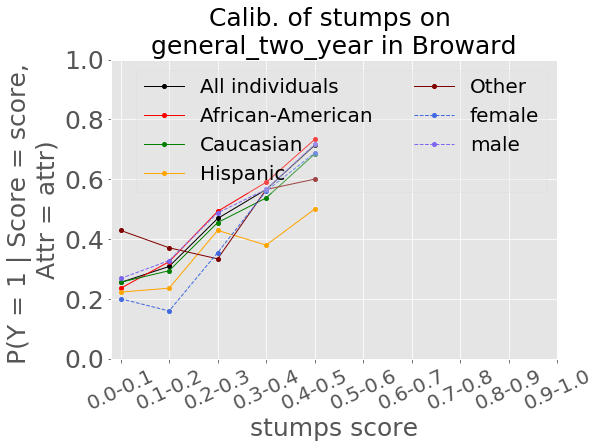

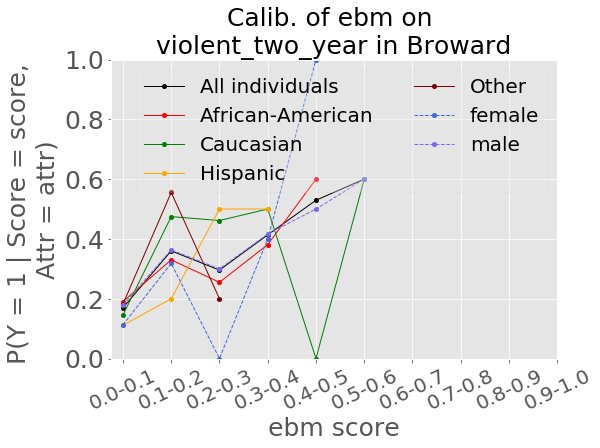

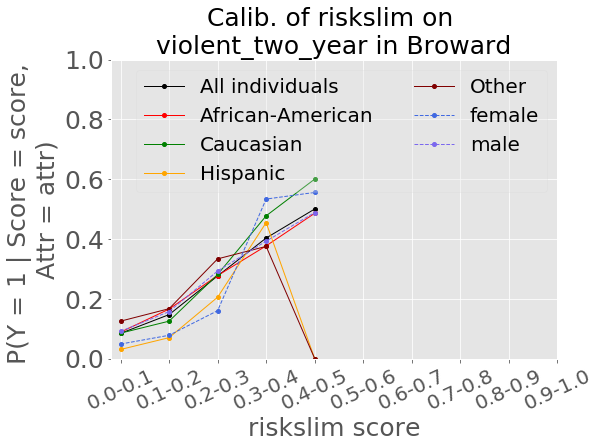

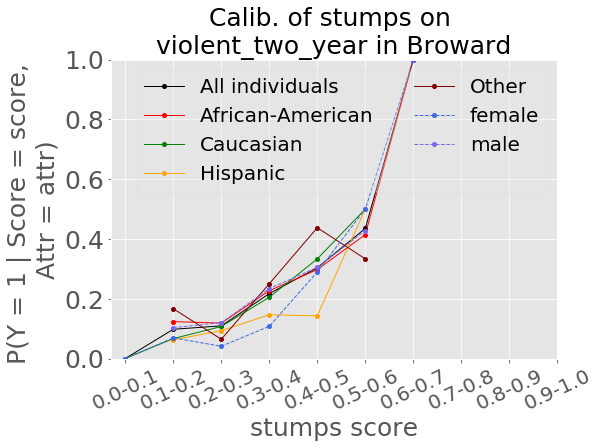

In [6]:
for name, calib_summary in calibration_data.items():
    recid_type, time_period, score_name = name.split("-")
    problem_name = "_".join([recid_type, time_period])

    calib, calib_grps = parse_calibration_matrix(calibration_matrix=calib_summary, 
                                                 problem_name=problem_name, 
                                                 score_name=score_name)
    
    include_legend=True
#     if recid_type == 'violent':
#         include_legend=True
        
    plot_calibration_for_score_on_problem(calib=calib,
                                          calib_grps=calib_grps,
                                          problem_name=problem_name,
                                          score_name=score_name,
                                          region="Broward",
                                          xtick_labels=['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5','0.5-0.6', 
                                                        '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0'],
                                          rotate_xticks=True,
                                          include_legend=include_legend,
                                          save_path="broward/logs/fairness_results/calibration_visualizations/" 
                                                      + score_name + "/" 
                                                      + score_name + "_" + problem_name + ".pdf")
    